# 数据下载

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [4]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = ( DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data=pd.read_csv(download('kaggle_house_train'))
test_data=pd.read_csv(download('kaggle_house_test'))

print(train_data.shape,test_data.shape)

(1460, 81) (1459, 80)


In [5]:
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


# 数据预处理

In [12]:
# 第一列为序号，将其从数据集中删除
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

#### 处理缺失值、标准化数据

In [13]:
# 取得所有非字符的标签
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# 对所有非字符的标签进行标准化
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，可能还会有新的缺失值，将缺失值填充为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

#### 处理离散值（独热编码）

In [14]:
all_features = pd.get_dummies(all_features, dummy_na=True,dtype=int)
all_features.shape

(2919, 330)

#### 提取Numpy格式，并转化为张量表示

In [15]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

# 训练

#### 定义损失函数

In [23]:
loss=nn.MSELoss()

#### 定义线性模型

In [24]:
# in_features是输入的特征数
in_features=train_features.shape[1]

def get_net():
    # 单层线性回归模型
    net=nn.Sequential(nn.Linear(in_features,1))
    return net

#### 相对误差

In [25]:
def log_rmse(net,features,labels):
    # clipped_preds是net(features)中所有元素的最大值不超过1，最小值不小于1的新张量
    clipped_preds=torch.clamp(net(features),1,float('inf'))
    # 计算均方误差，并将其开方，再取对数，最后返回其均值
    rmse=torch.sqrt(loss(clipped_preds.log(),labels.log()))
    return rmse.item()

#### 训练函数

In [26]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    
    # 定义train_ls和test_ls，保存训练损失和测试损失
    train_ls, test_ls = [], []
    
    # 定义 train_iter 迭代器
    # 调用load_array函数，将train_features和train_labels作为输入参数，以及batch_size作为输入参数，使用is_train=True
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    
    # 这里使用的是Adam优化算法，所以要对权重参数进行衰减
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    
    # 开始训练
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

# K折交叉验证

#### 定义K折交叉验证模型

In [27]:
def get_kfold(k,i,X,y):
    #断言k>1
    assert k>1
    
    # 计算每个折的样本数量
    fold_size=X.shape[0]//k
    
    # 初始化训练集和验证集
    X_train,y_train=None,None
    
    # 遍历每个折
    for j in range(k):
        # 计算当前折的索引范围
        idx=slice(j*fold_size,(j+1)*fold_size)
        #X_part,y_part是当前折的特征和标签
        X_part,y_part=X[idx,:],y[idx]
        
        # 如果当前折是第i折，则将其作为验证集
        if j==i:
            # 当前折作为验证集
            X_val,y_val=X_part,y_part
        elif X_train is None:
            # 第一个折作为训练集
            X_train,y_train=X_part,y_part
        else:
            # 其余折作为训练集
            X_train=torch.cat([X_train,X_part],axis=0)
            y_train=torch.cat([y_train,y_part],axis=0)
            
    # 返回训练集和验证集
    return X_train,y_train,X_val,y_val

#### 返回K折交叉验证的损失

In [28]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    #定义train_l_sum和valid_l_sum，保存训练损失和验证损失
    train_l_sum, valid_l_sum = 0, 0
    
    # 遍历每个折, 每次返回一个训练集和验证集, 并训练模型
    for i in range(k):
        data = get_kfold(k, i, X_train, y_train)
        net = get_net()
        # 训练模型，并返回训练损失和验证损失
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        
        # 保存训练损失和验证损失
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        
        # 绘制训练损失和验证损失
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    
    # 返回训练损失和验证损失的平均值
    return train_l_sum / k, valid_l_sum / k

# 模型选择

折1，训练log rmse0.170653, 验证log rmse0.156779
折2，训练log rmse0.162236, 验证log rmse0.191097
折3，训练log rmse0.164111, 验证log rmse0.168776
折4，训练log rmse0.168194, 验证log rmse0.155008
折5，训练log rmse0.162496, 验证log rmse0.182815
5-折验证: 平均训练log rmse: 0.165538, 平均验证log rmse: 0.170895


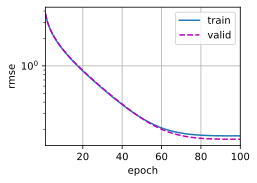

In [29]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

# 计算损失结果

In [30]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162341


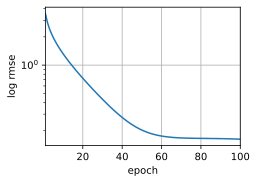

In [31]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)